## 노선 중복도의 개념
이번에는 노선 굴곡도와 더불어, 노선의 효율성 지표로 활용되는 노선 중복도를 구해봅니다.
노선의 중복도는 동일한 버스노선에 다른 노선이 운행되는 것을 의미합니다.
노선의 중복도는 시내버스 수요에 비해 노선이 과다 공급됨으로써, 상대적으로 노선이 필요한 지역에 노선을 공급하지 못하는 비효율을 초래하게 됩니다.

여기서 노선 중복도는, 기존과 다르게 다음과 같이 계산합니다.
노선 A의 구간에 다른 노선 B의 구간이 얼마나 있는지 그 비율을 측정합니다.
식으로는, A와 B 노선의 중복도 = (A와 B 노선에 겹치는 구간) / (A 노선의 전 구간) 입니다.
즉, A의 노선과 B의 노선이 전반적으로 비슷하면, 노선 중복도는 매우 높을 것이고, 우리는 어떤 노선쌍이 중복도가 높은지 찾고자 하는 것입니다.

Part 2 에서와 마찬가지로, 화성시 시내 안에서만 운행되는 노선만 대상으로 합니다.
노선 중복도가 높은 노선 쌍을 뽑아보고, 시각화를 통해 실제로 어떻게 생긴 노선들인지 살펴보겠습니다.

In [27]:
import os

# for data aggregation.
import numpy as np
import pandas as pd
import geopandas as gpd
from geopy.distance import distance, lonlat

# for data visualisation.
import matplotlib.pyplot as plt
#import chart_studio.plotly as py
#import cufflinks as cf 
#cf.go_offline(connected=True)
#cf.set_config_file(theme='polar')
import deckgljupyter.Layer as deckgl
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
sns.__version__

'0.9.0'

In [28]:
#access_token = os.getenv('MAPBOX_ACCESS_TOKEN')
access_token = 'pk.eyJ1IjoicmxmZHVkd28iLCJhIjoiY2szaXppbHR2MGNucjNob2N1Z2hxNDF0cSJ9.RGDa37zeGnx4n8NabU5Skg'
view_options = {
    'center': [126.908, 37.132],
    'zoom': 12,
    'bearing': 0,
    'pitch': 60,
    'style': 'mapbox://styles/mapbox/dark-v9',
    'access_token': access_token
}

def get_random_color(opacity=1):
    """
        deckgl.Layer 파라미터 중 getColor 에 값을 주는데 쓰입니다.
    """
    rgba = np.random.choice(range(256), size=3).tolist()
    rgba.append(opacity*255)
    return rgba


def draw_path(path_list, name_list=None, colors=[], opacity=1): 
    """
        path_list 로 넘어온 path 들을 한 지도 안에 그립니다.
    """
    # 시각화할 데이터 형태로 가공
    data = []
    for i, path in enumerate(path_list):
        d = {
            'path': path,
            'color': get_random_color() if len(colors) == 0 else colors[i]
        }
        if name_list != None:
            d['name'] = name_list[i]
        data.append(d)
            
    # 지도 설정
    v = view_options.copy()
    v['center'] = np.mean(path_list[0], axis=0)
    
    # 지도그리기
    m = deckgl.Map(**view_options)
    m.add(deckgl.PathLayer(data,
                           getWidth=20,
                           getColor='obj => obj.color',
                           opacity=opacity,
                           pickable=True,
                           tooltip=['name']))
    
    m.show()

In [29]:
df_route_info = pd.read_csv('../data/PJT001_routestationinfo.csv')

df_route_info.shape
df_route_info.head()

(37831, 7)

,seq,pr_station_id,bus_line_no,bus_line_no_seq,station_nm,station_id,mobile_no
0,65286,228000018,10-4,1,용인터미널,228001552,47634.0
1,65287,228000018,10-4,2,용인터미널(경유),277102443,NaN
2,65288,228000018,10-4,3,포브스병원,228000443,29439.0
3,65289,228000018,10-4,4,제일교회,228000665,29881.0
4,65290,228000018,10-4,5,라이프아파트,228000664,29457.0


In [30]:
df_route_station = pd.read_csv('../data/PJT001_stations_table.csv')

In [31]:
df_route_station.columns

Index(['표준정류장ID', '시군명', '정류소명', '정류소영문명', '정류소번호', '중앙차로여부', '관할관청', '위치',
       'WGS84위도', 'WGS84경도', '모바일정류장ID', '이비카드정류장ID'],
      dtype='object')

In [32]:
df_route_station.columns = ['STATION_ID', '시군명', '정류소명', '정류소영문명', '정류소번호', '중앙차로여부', '관할관청', '위치',
       'MAP_LAT','MAP_LON', 'mobile_no', '이비카드정류장ID']

In [33]:
df_route_info.columns = ['seq','ROUTE_ID','ROUTE_NM','SEQ','STATION_NM','STATION_ID','mobile_no']

In [34]:
df_route_station = df_route_station[['STATION_ID','MAP_LAT','MAP_LON']]

In [35]:
df_route_station

,STATION_ID,MAP_LAT,MAP_LON
0,228003422,37.342517,127.066817
1,228003423,37.341800,127.068983
2,228003424,37.341817,127.069083
3,228003425,37.339350,127.073067
4,228003426,37.339183,127.073400
...,...,...,...
38504,228003381,37.326433,127.071317
38505,228003382,37.326450,127.071100
38506,236001229,38.050650,127.306617
38507,236001230,38.005517,127.245667


In [36]:
df_route_info = pd.merge(df_route_info, df_route_station,how = 'left', on ='STATION_ID')

# 노선 중복도 구하기

## 노선 쌍의 중복도 구하기

동탄 지나는 버스만으로 걸러내기

In [37]:
# ods[route_id] 에 route_id 노선의 전 구간을 set 에 담습니다.
ods = {}
grp = df_route_info.groupby('ROUTE_ID')

for route_id, gdf in grp:
    gdf = gdf.sort_values('SEQ')
    od_set = set()
    for i in range(1, len(gdf)):
        od = (gdf['STATION_ID'].iloc[i-1], gdf['STATION_ID'].iloc[i])
        od_set.add(od)
    ods[route_id] = od_set

In [38]:
# diff_routes[route_id1][route_id2] 에 노선 route_id1와 route_id2 간의 중복도 값을 구합니다.
diff_routes = {}
for route_id1, od_set1 in ods.items():
    d = {}
    
    for route_id2, od_set2 in ods.items():
        diff = od_set1 & od_set2
        d[route_id2] = len(diff) / len(od_set1)
    diff_routes[route_id1] = d

In [39]:
# 위에서 구한 두 노선의 중복도 값을 데이터프레임으로 만들어줍니다.
# 0~1의 값을 0~100(%) 로 바꿔줍니다.
df_redundancy = pd.DataFrame(diff_routes)
df_redundancy = df_redundancy * 100
df_redundancy.head()

,228000018,228000020,228000021,228000055,228000081,228000113,228000128,228000136,228000148,228000159,...,241489001,241489008,241491002,241491003,241491004,241491005,241491008,241491009,241491010,241491011
228000018,100.000000,5.555556,8.510638,6.779661,0.000000,7.692308,4.0,3.529412,5.504587,13.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228000020,3.030303,100.000000,6.382979,5.084746,5.882353,38.461538,0.0,36.470588,2.752294,30.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228000021,4.040404,5.555556,100.000000,5.084746,3.921569,13.461538,0.0,43.529412,3.669725,20.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228000055,4.040404,5.555556,6.382979,100.000000,0.000000,5.769231,0.0,3.529412,2.752294,10.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228000081,0.000000,5.555556,4.255319,0.000000,100.000000,25.000000,0.0,5.882353,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Figure size 1296x1296 with 0 Axes>

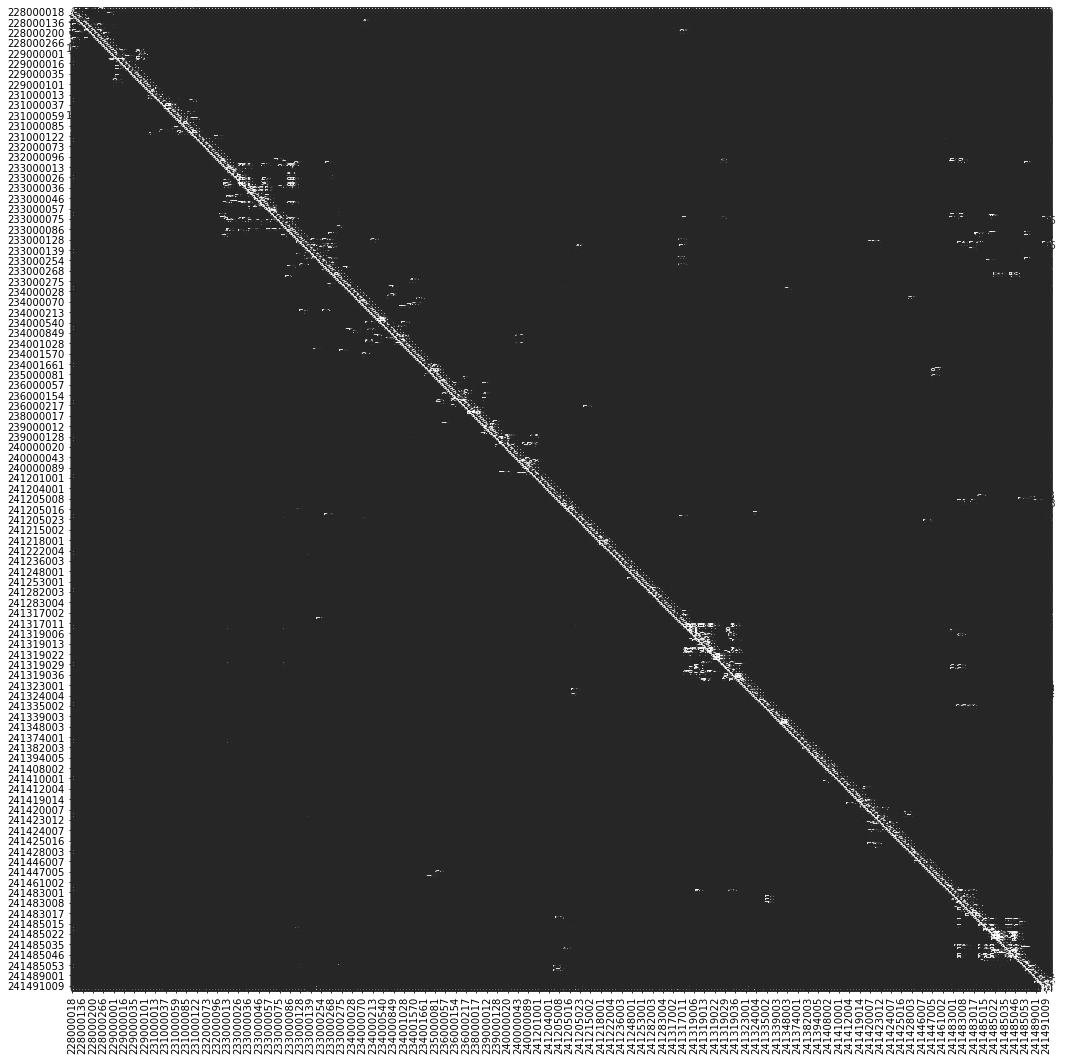

In [40]:
plt.figure(figsize=(18, 18))
sns.heatmap(df_redundancy, square=True, annot=True, fmt='.0f', cmap='Blues', cbar=False, vmin=0, vmax=100)
plt.show()

In [41]:
redundancy_flat = df_redundancy.values.flatten()
redundancy_flat = [i for i in redundancy_flat if i != 100]

In [42]:
pd.Series(redundancy_flat).iplot(kind='hist')

AttributeError: 'Series' object has no attribute 'iplot'

In [ ]:
pd.Series(redundancy_flat).describe()

## 중복도 기준치 넘는 노선쌍 추출하기

0의 값이 많지만, 최대 97% 중복되는 노선 쌍도 있습니다.
중복도 80%를 기준으로 이 수치를 넘는 노선 쌍만 추출해보겠습니다.

In [ ]:
topn_pair = {}
for route_id1, others in diff_routes.items():
    for route_id2, redundancy in others.items():
        if route_id1 == route_id2:
            continue
        if redundancy >= 0.8 and (topn_pair.get((route_id2, route_id1), None) == None):
            topn_pair[(route_id1, route_id2)] = redundancy

In [ ]:
len(topn_pair)

## 노선쌍 시각화

In [ ]:
# 먼저 위에서 구한 노선쌍의 중복도를 데이터프레임으로 만듭니다.
df_topn_pair = pd.Series(topn_pair).to_frame().reset_index()
df_topn_pair.columns = ['route_1', 'route_2', 'redundancy']
df_topn_pair.sort_values('redundancy', ascending=False, inplace=True)
df_topn_pair.head()

In [ ]:
def get_route_path(route_id):
    idx = df_route_info['ROUTE_ID'] == route_id
    return df_route_info[idx][['MAP_LON', 'MAP_LAT']].values.tolist()

def get_route_name(route_id):
    idx = df_route_info['ROUTE_ID'] == route_id
    return df_route_info[idx]['ROUTE_NM'].iloc[0]

일단 지도 하나에, 한 번에 그려서 한 번에 보겠습니다.

In [ ]:
d = {}
path_list, name_list = [], []

for i, row in df_topn_pair.iterrows():
    if d.get(row['route_1'], None) == None:
        path_list.append(get_route_path(row['route_1']))
        name_list.append(get_route_name(row['route_1']))
        d[row['route_1']] = True
    if d.get(row['route_2'], None) == None:  
        path_list.append(get_route_path(row['route_2']))
        name_list.append(get_route_name(row['route_2']))
        d[row['route_2']] = True

In [ ]:
draw_path(path_list, name_list, colors=[[255, 233, 0]]*len(path_list), opacity=0.01)

조암 터미널 근처에 중복된 노선이 제일 많아보입니다.
이번엔 노선 쌍별로 띄어놓고 보겠습니다.

## 정리
이번 파트에서는, 노선 쌍의 중복도를 구해보고 이를 시각화해서 직접 살펴봤습니다.
노선 중복이 80% 를 넘는 노선들만 살펴보았고, 이 중에는 최대 98% 되는 노선도 있었습니다.
특히, 조암터미널 주위로 중복도가 높았습니다.

노선이 중복되게 설정해놓은 이유가 분명 있을테지만,
이후 노선 개편을 생각한다면, 위의 26개의 노선들을 우선적으로 살펴볼 필요가 있을 듯 합니다.

In [ ]:
# 노선 route_1 와 중복되는 노선이 여러개 있으면, 한번에 보여줍니다.
for route_1, gdf in df_topn_pair.groupby('route_1'):
    path_list, name_list = [], []
    path_list.append(get_route_path(route_1))
    name_list.append(get_route_name(route_1))
    
    print(name_list[0], route_1)
    print("-------------------")
    
    # 각 노선이 겹치지 않게, 노선의 위도 경도에 alpha 만큼 더해줍니다.
    alpha = 0.0005
    extra = np.array([alpha, alpha])
    for i, row in gdf.iterrows():
        
        path_list.append((np.array(get_route_path(row['route_2'])) + extra).tolist())
        name_list.append(get_route_name(row['route_2']))
        extra += np.array([alpha, alpha])

        print(name_list[-1], "%.2f"%row['redundancy'])
        
    draw_path(path_list, name_list, opacity=1)